Dataset can be found here:
https://www.kaggle.com/brilja/pokemon-mugshots-from-super-mystery-dungeon



In [10]:
import os,shutil,glob
from tqdm.notebook import tqdm
from skimage.transform import resize,rescale
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

In [17]:
import numpy as np

In [11]:
img_files = glob.glob("./../Data/pokemon/*.png")

In [12]:
len(img_files)

4881

In [137]:
images = []
for imgfile in tqdm(img_files[0:200]):
    img = mpimg.imread(imgfile)
    images.append(resize(img,(64,64,1)))

In [138]:
np.shape(images)

(200, 64, 64, 1)

In [123]:
from sklearn.model_selection import train_test_split

In [124]:
X_train, X_test, y_train, y_test = train_test_split(
    images,
    images,
    test_size=0.2,
    shuffle=True,
    random_state=42,
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2,
    shuffle=True,
    random_state=42,)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)


# X_train = X_train.astype('float32') / 255.
# X_test = X_test.astype('float32') / 255.
# X_val = X_val.astype('float32') / 255.
# y_train = y_train.astype('float32') / 255.
# y_test = y_test.astype('float32') / 255.
# y_val = y_val.astype('float32') / 255.

In [125]:
print(X_train.shape,X_test.shape,X_val.shape)
print(y_train.shape,y_test.shape,y_val.shape)

(640, 64, 64, 1) (200, 64, 64, 1) (160, 64, 64, 1)
(640, 64, 64, 1) (200, 64, 64, 1) (160, 64, 64, 1)


---------- 
Making model:

-----------

In [113]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

In [183]:
autoencoder = None
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

# x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [184]:
autoencoder.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 16, 16, 64)        369

---------- 
Training model:

-----------

In [185]:
history = autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(X_val, X_val))

Train on 640 samples, validate on 160 samples
Epoch 1/50
640/640 [==============================] - 5s 8ms/sample - loss: 0.6733 - val_loss: 0.6514
Epoch 2/50
640/640 [==============================] - 4s 7ms/sample - loss: 0.6610 - val_loss: 0.6393
Epoch 3/50
640/640 [==============================] - 4s 7ms/sample - loss: 0.6526 - val_loss: 0.6303
Epoch 4/50
640/640 [==============================] - 4s 7ms/sample - loss: 0.6399 - val_loss: 0.6175
Epoch 5/50
640/640 [==============================] - 4s 7ms/sample - loss: 0.6275 - val_loss: 0.6044
Epoch 6/50
640/640 [==============================] - 5s 7ms/sample - loss: 0.6183 - val_loss: 0.6033
Epoch 7/50
640/640 [==============================] - 5s 8ms/sample - loss: 0.6146 - val_loss: 0.5973
Epoch 8/50
640/640 [==============================] - 4s 7ms/sample - loss: 0.6105 - val_loss: 0.5927
Epoch 9/50
640/640 [==============================] - 5s 7ms/sample - loss: 0.6056 - val_loss: 0.5888
Epoch 10/50
640/640 [===============

KeyboardInterrupt: 

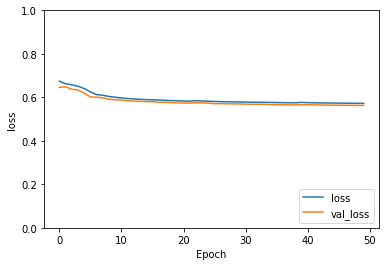

In [179]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

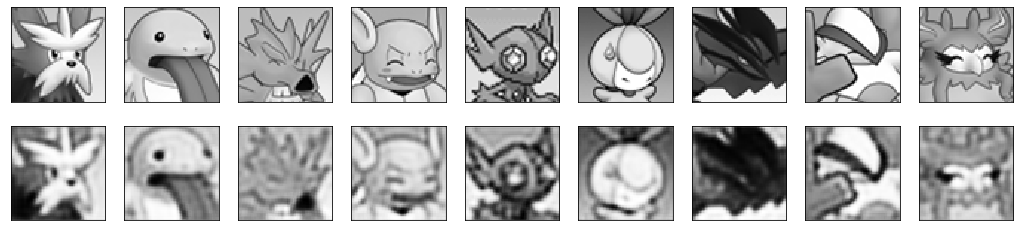

In [180]:
decoded_imgs = autoencoder.predict(X_train)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_train[i][:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i][:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()